In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim, autograd
from torch.nn import functional as F
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
#import input_data
from sklearn.utils import shuffle as skshuffle
from math import *
from backpack import backpack, extend
from backpack.extensions import KFAC
from sklearn.metrics import roc_auc_score
import scipy
from tqdm import tqdm, trange
from backpack.core.layers import Flatten
import pytest
import matplotlib.pyplot as plt
from DirLPA_utils import * 

print("pytorch version: ", torch.__version__)
print("torchvision version: ", torchvision.__version__)
print("cuda available: ", torch.cuda.is_available())

np.random.seed(42)
torch.manual_seed(42)

pytorch version:  1.2.0
torchvision version:  0.4.0a0+6b959ee
cuda available:  True


# Train Cifar10 on Resnet32

In [2]:
BATCH_SIZE_TRAIN_CIFAR10 = 128
BATCH_SIZE_TEST_CIFAR10 = 128

In [3]:
def get_accuracy(output, targets):
    """Helper function to print the accuracy"""
    predictions = output.argmax(dim=1, keepdim=True).view_as(targets)
    return predictions.eq(targets).float().mean().item()

def get_alpha_from_Normal_smart(mu, Sigma):
    print("mu: ", mu[12])
    print("Sigma diagonal: ", Sigma[12])
    batch_size, K = mu.size(0), mu.size(1)
    alpha = torch.zeros(batch_size, K)
    sum_exp = torch.exp(-1*mu.cpu()).sum(dim=1)
    for j in range(batch_size):
        for k in range(K):
            alpha[j][k] = 1/Sigma[j][k][k]*(1 - 2/K + torch.exp(mu[j][k])/K**2 * sum_exp[j])
        
    return(torch.Tensor(alpha))

In [4]:
@torch.no_grad()
def predict_laplace(model, test_loader, M_W_post, M_b_post, U_post, V_post, B_post, n_samples, verbose=False):
    py = []

    for batch_idx, (x, y) in enumerate(test_loader):
        x, y = x.cuda(), y.cuda()
        max_len = len(test_loader)

        phi = model.phi(x)

        mu_pred = phi @ M_W_post + M_b_post
        Cov_pred = torch.diag(phi @ U_post @ phi.t()).reshape(-1, 1, 1) * V_post.unsqueeze(0) + B_post.unsqueeze(0)

        post_pred = MultivariateNormal(mu_pred, Cov_pred)
        #print("mu_pred, Cov_pred: ", mu_pred.size(), Cov_pred.size())
        
        # MC-integral
        py_ = 0

        for _ in range(n_samples):
            f_s = post_pred.rsample()
            py_ += torch.softmax(f_s, 1)

        py_ /= n_samples
        py_ = py_.detach()
        
        #print("py len: ", len(py))
        #print("py_: ", py_.size())

        py.append(py_)
        #del phi
        #del mu_pred
        #del Cov_pred
        #del post_pred
        #del py_
        #del f_s
        
        if verbose:
            print("Batch: {}/{}".format(batch_idx, max_len))

    return torch.cat(py, dim=0)

In [5]:
@torch.no_grad()
def predict_DIR_LPA(model, test_loader, M_W_post, M_b_post, U_post, V_post, B_post, verbose=False):
    #num_classes = M_b_post.size(0)
    #alphas = torch.zeros(10000, num_classes) #i need to automate the 10000
    alphas = []

    for batch_idx, (x, y) in enumerate(test_loader):
        x = x.cuda()
        max_len = len(test_loader)

        phi = model.phi(x)

        mu_pred = phi @ M_W_post + M_b_post
        Cov_pred = torch.diag(phi @ U_post @ phi.t()).reshape(-1, 1, 1) * V_post.unsqueeze(0) + B_post.unsqueeze(0)
        #print("mu, cov size: ", mu_pred.size(), Cov_pred.size())
        
        #print("Sigma diagonal: ", Cov_pred.diagonal())
    
        alpha = get_alpha_from_Normal_smart(mu_pred, Cov_pred)
        print("alpha: ", alpha[12])
        #alpha = get_alpha_from_Normal(mu_pred.view(10), Cov_pred.view(10,10))
        alpha /= alpha.sum(dim=1).view(-1,1).detach()
        alpha = alpha.detach()
        
        alphas.append(alpha)
        
        
        if verbose:
            print("Batch: {}/{}".format(batch_idx, max_len))

    return(torch.cat(alphas, dim = 0))

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


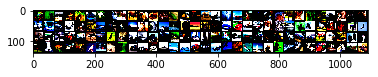

In [6]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=True,
                                        download=True, transform=transform_train)

train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size
CIFAR10_train_dataset, CIFAR10_val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

CIFAR10_train_loader = torch.utils.data.DataLoader(CIFAR10_train_dataset, batch_size=BATCH_SIZE_TRAIN_CIFAR10,
                                          shuffle=False)

CIFAR10_val_loader = torch.utils.data.DataLoader(CIFAR10_val_dataset, batch_size=BATCH_SIZE_TRAIN_CIFAR10,
                                          shuffle=False)

CIFAR10_test = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=False,
                                       download=True, transform=transform_test)
CIFAR10_test_loader = torch.utils.data.DataLoader(CIFAR10_test, batch_size=BATCH_SIZE_TEST_CIFAR10,
                                         shuffle=False)

CIFAR10_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(CIFAR10_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_CIFAR10/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

In [7]:
#load in CIFAR100
BATCH_SIZE_TRAIN_CIFAR100 = 128
BATCH_SIZE_TEST_CIFAR100 = 32

CIFAR100_test = torchvision.datasets.CIFAR100(root='~/data/cifar100', train=False,
                                       download=True, transform=transform_test)
CIFAR100_test_loader = torch.utils.data.DataLoader(CIFAR100_test, batch_size=BATCH_SIZE_TEST_CIFAR100,
                                         shuffle=False)

CIFAR100_classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

Files already downloaded and verified


In [8]:
# load SVHN
BATCH_SIZE_TRAIN_SVHN = 128
BATCH_SIZE_TEST_SVHN = 128

test_data_SVHN = torchvision.datasets.SVHN('~/data/SVHN', split='test',
                             download=True, transform=transform_test)

test_loader_SVHN = torch.utils.data.DataLoader(test_data_SVHN, batch_size=BATCH_SIZE_TEST_SVHN)

Using downloaded and verified file: /home/marius/data/SVHN/test_32x32.mat


# Train CIFAR10 on ResNet18

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


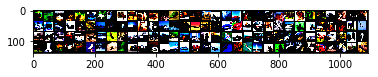

In [10]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(CIFAR10_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_CIFAR10/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

In [11]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.fc = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def phi(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return out
    
    def forward(self, x):
        out = self.phi(x)
        out = self.fc(out)
        return(out)


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
CIFAR10_model = ResNet18().to(device)
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CIFAR10_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

In [14]:
# Training
def train(net, epoch, optimizer, filename):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    
    print("train loss: ", train_loss)
    print("train accuracy: ", correct/total)
    print("saving model at: {}".format(filename))
    torch.save(net.state_dict(), filename)

In [15]:
def test(net, epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
        print("test loss: ", test_loss)
        print("test accuracy: ", correct/total)

In [16]:
def train_all():
    CIFAR10_path = 'weights/cifar10_resnet18_SGD.pth'
    lr = 0.1
    epoch = 0
    for e in [100, 50, 50]:
        print("current learning rate: ", lr)
        for _ in range(e):
            optimizer = optim.SGD(CIFAR10_model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
            train(CIFAR10_model, epoch, optimizer, CIFAR10_path)
            test(CIFAR10_model, epoch)
            epoch += 1
        lr /= 10

In [17]:
#train_all()

In [18]:
##### if you already have a trained model ##############
CIFAR10_PATH = 'weights/cifar10_resnet18_SGD.pth'
CIFAR10_model = ResNet18().to(device)
print("loading model from: {}".format(CIFAR10_PATH))
CIFAR10_model.load_state_dict(torch.load(CIFAR10_PATH))#, map_location=torch.device('cpu')))
#test the model
test(CIFAR10_model, 0)

loading model from: weights/cifar10_resnet18_SGD.pth
test loss:  18.794341979548335
test accuracy:  0.9502


In [19]:
M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D = Diag_second_order(model=CIFAR10_model,
                                                               batch_size=128,
                                                               train_loader=trainloader,
                                                               var0 = 10,
                                                               device='cuda')

n: 512 inputs to linear layer with m: 10 classes
Batch: 0/391
Batch: 1/391
Batch: 2/391
Batch: 3/391
Batch: 4/391
Batch: 5/391
Batch: 6/391
Batch: 7/391
Batch: 8/391
Batch: 9/391
Batch: 10/391
Batch: 11/391
Batch: 12/391
Batch: 13/391
Batch: 14/391
Batch: 15/391
Batch: 16/391
Batch: 17/391
Batch: 18/391
Batch: 19/391
Batch: 20/391
Batch: 21/391
Batch: 22/391
Batch: 23/391
Batch: 24/391
Batch: 25/391
Batch: 26/391
Batch: 27/391
Batch: 28/391
Batch: 29/391
Batch: 30/391
Batch: 31/391
Batch: 32/391
Batch: 33/391
Batch: 34/391
Batch: 35/391
Batch: 36/391
Batch: 37/391
Batch: 38/391
Batch: 39/391
Batch: 40/391
Batch: 41/391
Batch: 42/391
Batch: 43/391
Batch: 44/391
Batch: 45/391
Batch: 46/391
Batch: 47/391
Batch: 48/391
Batch: 49/391
Batch: 50/391
Batch: 51/391
Batch: 52/391
Batch: 53/391
Batch: 54/391
Batch: 55/391
Batch: 56/391
Batch: 57/391
Batch: 58/391
Batch: 59/391
Batch: 60/391
Batch: 61/391
Batch: 62/391
Batch: 63/391
Batch: 64/391
Batch: 65/391
Batch: 66/391
Batch: 67/391
Batch: 68

In [20]:
M_W_post, M_b_post, U_post, V_post, B_post = KFLP_second_order(model=CIFAR10_model,
                                                               batch_size=128,
                                                               train_loader=trainloader,
                                                               var0 = 10,
                                                               device='cuda')

Batch: 0/391
Batch: 1/391
Batch: 2/391
Batch: 3/391
Batch: 4/391
Batch: 5/391
Batch: 6/391
Batch: 7/391
Batch: 8/391
Batch: 9/391
Batch: 10/391
Batch: 11/391
Batch: 12/391
Batch: 13/391
Batch: 14/391
Batch: 15/391
Batch: 16/391
Batch: 17/391
Batch: 18/391
Batch: 19/391
Batch: 20/391
Batch: 21/391
Batch: 22/391
Batch: 23/391
Batch: 24/391
Batch: 25/391
Batch: 26/391
Batch: 27/391
Batch: 28/391
Batch: 29/391
Batch: 30/391
Batch: 31/391
Batch: 32/391
Batch: 33/391
Batch: 34/391
Batch: 35/391
Batch: 36/391
Batch: 37/391
Batch: 38/391
Batch: 39/391
Batch: 40/391
Batch: 41/391
Batch: 42/391
Batch: 43/391
Batch: 44/391
Batch: 45/391
Batch: 46/391
Batch: 47/391
Batch: 48/391
Batch: 49/391
Batch: 50/391
Batch: 51/391
Batch: 52/391
Batch: 53/391
Batch: 54/391
Batch: 55/391
Batch: 56/391
Batch: 57/391
Batch: 58/391
Batch: 59/391
Batch: 60/391
Batch: 61/391
Batch: 62/391
Batch: 63/391
Batch: 64/391
Batch: 65/391
Batch: 66/391
Batch: 67/391
Batch: 68/391
Batch: 69/391
Batch: 70/391
Batch: 71/391
Ba

In [21]:
targets_CIFAR10 = testset.targets
targets_CIFAR100 = CIFAR100_test.targets
targets_SVHN = []
for x,y in test_loader_SVHN:
    targets_SVHN.append(y)
targets_SVHN = torch.cat(targets_SVHN).numpy()

# MAP estimate

In [22]:
CIFAR10_test_in_MAP = predict_MAP(CIFAR10_model, testloader, cuda=True).cpu().numpy()
CIFAR10_test_out_CIFAR100_MAP = predict_MAP(CIFAR10_model, CIFAR100_test_loader, cuda=True).cpu().numpy()
CIFAR10_test_out_SVHN_MAP = predict_MAP(CIFAR10_model, test_loader_SVHN, cuda=True).cpu().numpy()

In [23]:
acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP = get_in_dist_values(CIFAR10_test_in_MAP, targets_CIFAR10)
acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP = get_out_dist_values(CIFAR10_test_in_MAP, CIFAR10_test_out_CIFAR100_MAP, targets_CIFAR100)
acc_out_SVHN_MAP, prob_correct_out_SVHN_MAP, ent_out_SVHN, MMC_out_SVHN_MAP, auroc_out_SVHN_MAP = get_out_dist_values(CIFAR10_test_in_MAP, CIFAR10_test_out_SVHN_MAP, targets_SVHN)

In [24]:
print_in_dist_values(acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP, 'CIFAR10', 'MAP')
print_out_dist_values(acc_out_CIFAR100_MAP, prob_correct_out_CIFAR100_MAP, ent_out_CIFAR100, MMC_out_CIFAR100_MAP, auroc_out_CIFAR100_MAP, 'CIFAR100', 'MAP')
print_out_dist_values(acc_out_SVHN_MAP, prob_correct_out_SVHN_MAP, ent_out_SVHN, MMC_out_SVHN_MAP, auroc_out_SVHN_MAP, 'SVHN', 'MAP')

[In, MAP, CIFAR10] Accuracy: 0.950; average entropy: 0.066;     MMC: 0.979; Prob @ correct: 0.944
[Out-MAP, KFAC, CIFAR100] Accuracy: 0.009; Average entropy: 0.500;    MMC: 0.825; AUROC: 0.877; Prob @ correct: 0.104
[Out-MAP, KFAC, SVHN] Accuracy: 0.095; Average entropy: 0.658;    MMC: 0.770; AUROC: 0.927; Prob @ correct: 0.095


# Diagonal estimate

In [25]:
CIFAR10_test_in_D = predict_diagonal_sampling(CIFAR10_model, testloader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=100, cuda=True).cpu().numpy()
CIFAR10_test_out_CIFAR100_D = predict_diagonal_sampling(CIFAR10_model, CIFAR100_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=100, cuda=True).cpu().numpy()
CIFAR10_test_out_SVHN_D = predict_diagonal_sampling(CIFAR10_model, test_loader_SVHN, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=100, cuda=True).cpu().numpy()

In [26]:
acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D = get_in_dist_values(CIFAR10_test_in_D, targets_CIFAR10)
acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100_D, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D = get_out_dist_values(CIFAR10_test_in_D, CIFAR10_test_out_CIFAR100_D, targets_CIFAR100)
acc_out_SVHN_D, prob_correct_out_SVHN_D, ent_out_SVHN_D, MMC_out_SVHN_D, auroc_out_SVHN_D = get_out_dist_values(CIFAR10_test_in_D, CIFAR10_test_out_SVHN_D, targets_SVHN)

In [27]:
print_in_dist_values(acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D, 'CIFAR10', 'Diag')
print_out_dist_values(acc_out_CIFAR100_D, prob_correct_out_CIFAR100_D, ent_out_CIFAR100, MMC_out_CIFAR100_D, auroc_out_CIFAR100_D, 'CIFAR100', 'Diag')
print_out_dist_values(acc_out_SVHN_D, prob_correct_out_SVHN_D, ent_out_SVHN_D, MMC_out_SVHN_D, auroc_out_SVHN_D, 'SVHN', 'Diag')

[In, Diag, CIFAR10] Accuracy: 0.950; average entropy: 0.066;     MMC: 0.979; Prob @ correct: 0.944
[Out-Diag, KFAC, CIFAR100] Accuracy: 0.009; Average entropy: 0.500;    MMC: 0.825; AUROC: 0.877; Prob @ correct: 0.104
[Out-Diag, KFAC, SVHN] Accuracy: 0.095; Average entropy: 0.658;    MMC: 0.770; AUROC: 0.927; Prob @ correct: 0.095


# KFAC estimate

In [28]:
CIFAR10_test_in_KFAC = predict_KFAC_sampling(CIFAR10_model, testloader, M_W_post, M_b_post, U_post, V_post, B_post, n_samples=100, cuda=True).cpu().numpy()
CIFAR10_test_out_CIFAR100_KFAC = predict_KFAC_sampling(CIFAR10_model, CIFAR100_test_loader, M_W_post, M_b_post, U_post, V_post, B_post, n_samples=100, cuda=True).cpu().numpy()
CIFAR10_test_out_SVHN_KFAC = predict_KFAC_sampling(CIFAR10_model, test_loader_SVHN, M_W_post, M_b_post, U_post, V_post, B_post, n_samples=100, cuda=True).cpu().numpy()

In [29]:
acc_in_KFAC, prob_correct_in_KFAC, ent_in_KFAC, MMC_in_KFAC = get_in_dist_values(CIFAR10_test_in_KFAC, targets_CIFAR10)
acc_out_CIFAR100_KFAC, prob_correct_out_CIFAR100_KFAC, ent_out_CIFAR100_KFAC, MMC_out_CIFAR100_KFAC, auroc_out_CIFAR100_KFAC = get_out_dist_values(CIFAR10_test_in_KFAC, CIFAR10_test_out_CIFAR100_KFAC, targets_CIFAR100)
acc_out_SVHN_KFAC, prob_correct_out_SVHN_KFAC, ent_out_SVHN_KFAC, MMC_out_SVHN_KFAC, auroc_out_SVHN_KFAC = get_out_dist_values(CIFAR10_test_in_KFAC, CIFAR10_test_out_SVHN_KFAC, targets_SVHN)

In [30]:
print_in_dist_values(acc_in_KFAC, prob_correct_in_KFAC, ent_in_KFAC, MMC_in_KFAC, 'CIFAR10', 'KFAC')
print_out_dist_values(acc_out_CIFAR100_KFAC, prob_correct_out_CIFAR100_KFAC, ent_out_CIFAR100_KFAC, MMC_out_CIFAR100_KFAC, auroc_out_CIFAR100_KFAC, 'CIFAR100', 'KFAC')
print_out_dist_values(acc_out_SVHN_KFAC, prob_correct_out_SVHN_KFAC, ent_out_SVHN_KFAC, MMC_out_SVHN_KFAC, auroc_out_SVHN_KFAC, 'SVHN', 'KFAC')

[In, KFAC, CIFAR10] Accuracy: 0.950; average entropy: 0.996;     MMC: 0.751; Prob @ correct: 0.737
[Out-KFAC, KFAC, CIFAR100] Accuracy: 0.009; Average entropy: 1.618;    MMC: 0.475; AUROC: 0.879; Prob @ correct: 0.101
[Out-KFAC, KFAC, SVHN] Accuracy: 0.095; Average entropy: 1.750;    MMC: 0.415; AUROC: 0.930; Prob @ correct: 0.095


# Dirichlet Laplace estimate

In [31]:
def get_alpha_from_Normal(mu, Sigma):
    batch_size, K = mu.size(0), mu.size(-1)
    Sigma_d = torch.diagonal(Sigma, dim1=1, dim2=2)
    sum_exp = torch.sum(torch.exp(-1*mu), dim=1).view(-1,1)
    alpha = 1/Sigma_d * (1 - 2/K + torch.exp(mu)/K**2 * sum_exp)
    
    return(alpha)

In [32]:
@torch.no_grad()
def predict_DIR_LPA(model, test_loader, M_W_post, M_b_post, U_post, V_post, B_post, verbose=False, cuda=False):
    alphas = []

    max_len = int(np.ceil(len(test_loader.dataset)/len(test_loader)))

    for batch_idx, (x, y) in enumerate(test_loader):
        
        if cuda:
            x, y = x.cuda(), y.cuda()

        phi = model.phi(x)

        mu_pred = phi @ M_W_post + M_b_post
        mu_pred -= mu_pred.mean(1).view(-1,1)
        Cov_pred = torch.diag(phi @ U_post @ phi.t()).reshape(-1, 1, 1) * V_post.unsqueeze(0) + B_post.unsqueeze(0)

        alpha = get_alpha_from_Normal(mu_pred, Cov_pred).detach()
        #alpha /= alpha.sum(dim=1).view(-1,1).detach()

        alphas.append(alpha)


        if verbose:
            print("Batch: {}/{}".format(batch_idx, max_len))

    return(torch.cat(alphas, dim = 0))

In [33]:
#CIFAR10_model = CIFAR10_model.cpu()
#M_W_post, M_b_post, U_post, V_post, B_post = M_W_post.cpu(), M_b_post.cpu(), U_post.cpu(), V_post.cpu(), B_post.cpu()
CIFAR10_model = CIFAR10_model.cuda()
M_W_post, M_b_post, U_post, V_post, B_post = M_W_post.cuda(), M_b_post.cuda(), U_post.cuda(), V_post.cuda(), B_post.cuda()
CIFAR10_test_in_DIR_LPA = predict_DIR_LPA(CIFAR10_model, testloader, M_W_post, M_b_post, U_post, V_post, B_post, cuda=True, verbose=False).cpu().numpy()
CIFAR10_test_out_CIFAR100_DIR_LPA = predict_DIR_LPA(CIFAR10_model, CIFAR100_test_loader, M_W_post, M_b_post, U_post, V_post, B_post, cuda=True).cpu().numpy()
CIFAR10_test_out_SVHN_DIR_LPA = predict_DIR_LPA(CIFAR10_model, test_loader_SVHN, M_W_post, M_b_post, U_post, V_post, B_post, cuda=True).cpu().numpy()

In [34]:
#normalize to get the MAP estimate (which is the mode) of the Dirichlet
CIFAR10_test_in_DIR_LPAn = CIFAR10_test_in_DIR_LPA/CIFAR10_test_in_DIR_LPA.sum(1).reshape(-1,1)
CIFAR10_test_out_CIFAR100_DIR_LPAn = CIFAR10_test_out_CIFAR100_DIR_LPA/CIFAR10_test_out_CIFAR100_DIR_LPA.sum(1).reshape(-1,1)
CIFAR10_test_out_SVHN_DIR_LPAn = CIFAR10_test_out_SVHN_DIR_LPA/CIFAR10_test_out_SVHN_DIR_LPA.sum(1).reshape(-1,1)

In [35]:
acc_in_DIR_LPA, prob_correct_in_DIR_LPA, ent_in_DIR_LPA, MMC_in_DIR_LPA = get_in_dist_values(CIFAR10_test_in_DIR_LPAn, targets_CIFAR10)
acc_out_CIFAR100_DIR_LPA, prob_correct_out_CIFAR100_DIR_LPA, ent_out_CIFAR100_DIR_LPA, MMC_out_CIFAR100_DIR_LPA, auroc_out_CIFAR100_DIR_LPA = get_out_dist_values(CIFAR10_test_in_DIR_LPAn, CIFAR10_test_out_CIFAR100_DIR_LPAn, targets_CIFAR100)
acc_out_SVHN_DIR_LPA, prob_correct_out_SVHN_DIR_LPA, ent_out_SVHN_DIR_LPA, MMC_out_SVHN_DIR_LPA, auroc_out_SVHN_DIR_LPA = get_out_dist_values(CIFAR10_test_in_DIR_LPAn, CIFAR10_test_out_SVHN_DIR_LPAn, targets_SVHN)

In [36]:
print_in_dist_values(acc_in_DIR_LPA, prob_correct_in_DIR_LPA, ent_in_DIR_LPA, MMC_in_DIR_LPA, 'CIFAR10', 'DIR_LPA')
print_out_dist_values(acc_out_CIFAR100_DIR_LPA, prob_correct_out_CIFAR100_DIR_LPA, ent_out_CIFAR100_DIR_LPA, MMC_out_CIFAR100_DIR_LPA, auroc_out_CIFAR100_DIR_LPA, 'CIFAR100', 'DIR_LPA')
print_out_dist_values(acc_out_SVHN_DIR_LPA, prob_correct_out_SVHN_DIR_LPA, ent_out_SVHN_DIR_LPA, MMC_out_SVHN_DIR_LPA, auroc_out_SVHN_DIR_LPA, 'SVHN', 'DIR_LPA')

[In, DIR_LPA, CIFAR10] Accuracy: 0.951; average entropy: 0.117;     MMC: 0.970; Prob @ correct: 0.938
[Out-DIR_LPA, KFAC, CIFAR100] Accuracy: 0.009; Average entropy: 0.754;    MMC: 0.771; AUROC: 0.861; Prob @ correct: 0.102
[Out-DIR_LPA, KFAC, SVHN] Accuracy: 0.096; Average entropy: 1.002;    MMC: 0.694; AUROC: 0.924; Prob @ correct: 0.098


# Do some additional stuff with the Dirichlet

In [37]:
from scipy.special import digamma, loggamma

def beta_function(alpha):
    return(np.exp(np.sum([loggamma(a_i) for a_i in alpha]) - loggamma(np.sum(alpha))))

def alphas_norm(alphas):
    alphas = np.array(alphas)
    return(alphas/alphas.sum(axis=1).reshape(-1,1))

def alphas_variance(alphas):
    alphas = np.array(alphas)
    norm = alphas_norm(alphas)
    nom = norm * (1 - norm)
    den = alphas.sum(axis=1).reshape(-1,1) + 1
    return(nom/den)

def log_beta_function(alpha):
    return(np.sum([loggamma(a_i) for a_i in alpha]) - loggamma(np.sum(alpha)))

def alphas_entropy(alphas):
    K = len(alphas[0])
    alphas = np.array(alphas)
    entropy = []
    for x in alphas:
        B = log_beta_function(x)
        alpha_0 = np.sum(x)
        C = (alpha_0 - K)*digamma(alpha_0)
        D = np.sum((x-1)*digamma(x))
        entropy.append(B + C - D)
    
    return(np.array(entropy))
        

def alphas_log_prob(alphas):
    alphas = np.array(alphas)
    dig_sum = digamma(alphas.sum(axis=1).reshape(-1,1))
    log_prob = digamma(alphas) - dig_sum
    return(log_prob)

def auroc_entropy(alphas_in, alphas_out):
    
    entropy_in = alphas_entropy(alphas_in)
    entropy_out = alphas_entropy(alphas_out)
    labels = np.zeros(len(entropy_in)+len(entropy_out), dtype='int32')
    labels[:len(entropy_in)] = 1
    examples = np.concatenate([entropy_in, entropy_out])
    auroc_ent = roc_auc_score(labels, examples)
    return(auroc_ent)

def auroc_variance(alphas_in, alphas_out, method='mean'):
    
    if method=='mean':
        variance_in = alphas_variance(alphas_in).mean(1)
        variance_out = alphas_variance(alphas_out).mean(1)
    elif method=='max':
        variance_in = alphas_variance(alphas_in).max(1)
        variance_out = alphas_variance(alphas_out).max(1)
    labels = np.zeros(len(variance_in)+len(variance_out), dtype='int32')
    labels[:len(variance_in)] = 1
    examples = np.concatenate([variance_in, variance_out])
    auroc_ent = roc_auc_score(labels, examples)
    return(auroc_ent)

In [38]:
print("auroc entropy: CIFAR10 in, CIFAR100 out: ", 1-auroc_entropy(alphas_in=CIFAR10_test_in_DIR_LPA, alphas_out=CIFAR10_test_out_CIFAR100_DIR_LPA))
print("auroc entropy: CIFAR10 in, SVHN out: ", 1-auroc_entropy(alphas_in=CIFAR10_test_in_DIR_LPA, alphas_out=CIFAR10_test_out_SVHN_DIR_LPA))

auroc entropy: CIFAR10 in, CIFAR100 out:  0.73900513
auroc entropy: CIFAR10 in, SVHN out:  0.8684601567301782


In [39]:
print("auroc variance: CIFAR10 in, CIFAR100 out: ", 1-auroc_variance(alphas_in=CIFAR10_test_in_DIR_LPA, alphas_out=CIFAR10_test_out_CIFAR100_DIR_LPA, method='mean'))
print("auroc variance: CIFAR10 in, SVHN out: ", 1-auroc_variance(alphas_in=CIFAR10_test_in_DIR_LPA, alphas_out=CIFAR10_test_out_SVHN_DIR_LPA, method='mean'))

auroc variance: CIFAR10 in, CIFAR100 out:  0.8629883899999999
auroc variance: CIFAR10 in, SVHN out:  0.9284247349416104


In [40]:
from scipy.special import digamma, loggamma, gamma

def beta_function(x,y):
    return np.exp(loggamma(x) + loggamma(y) - loggamma(x+y))

def get_prob_for_label(alphas):
    
    probs = []
    for alpha in alphas:
        probs_alpha = []
        a_sum = alpha.sum()
        for a_i in alpha:
            b = a_sum - a_i
            probs_alpha.append(beta_function(a_i + 1, b)/ beta_function(a_i, b))
        
        probs.append(probs_alpha)

    return(np.array(probs))


In [41]:
CIFAR10_test_in_DIR_LPA_bp = get_prob_for_label(CIFAR10_test_in_DIR_LPA)
CIFAR10_test_out_CIFAR100_DIR_LPA_bp = get_prob_for_label(CIFAR10_test_out_CIFAR100_DIR_LPA)
CIFAR10_test_out_SVHN_DIR_LPA_bp = get_prob_for_label(CIFAR10_test_out_SVHN_DIR_LPA)

In [42]:
acc_in_DIR_LPA_bp, prob_correct_in_DIR_LPA_bp, ent_in_DIR_LPA_bp, MMC_in_DIR_LPA_bp = get_in_dist_values(CIFAR10_test_in_DIR_LPA_bp, targets_CIFAR10)
acc_out_CIFAR100_DIR_LPA_bp, prob_correct_out_CIFAR100_DIR_LPA_bp, ent_out_CIFAR100_DIR_LPA_bp, MMC_out_CIFAR100_DIR_LPA_bp, auroc_out_CIFAR100_DIR_LPA_bp = get_out_dist_values(CIFAR10_test_in_DIR_LPA_bp, CIFAR10_test_out_CIFAR100_DIR_LPA_bp, targets_CIFAR100)
acc_out_SVHN_DIR_LPA_bp, prob_correct_out_SVHN_DIR_LPA_bp, ent_out_SVHN_DIR_LPA_bp, MMC_out_SVHN_DIR_LPA_bp, auroc_out_SVHN_DIR_LPA_bp = get_out_dist_values(CIFAR10_test_in_DIR_LPA_bp, CIFAR10_test_out_SVHN_DIR_LPA_bp, targets_SVHN)

In [43]:
print_in_dist_values(acc_in_DIR_LPA_bp, prob_correct_in_DIR_LPA_bp, ent_in_DIR_LPA_bp, MMC_in_DIR_LPA_bp, 'CIFAR10', 'DIR_LPA_bp')
print_out_dist_values(acc_out_CIFAR100_DIR_LPA_bp, prob_correct_out_CIFAR100_DIR_LPA_bp, ent_out_CIFAR100_DIR_LPA_bp, MMC_out_CIFAR100_DIR_LPA_bp, auroc_out_CIFAR100_DIR_LPA_bp, 'CIFAR100', 'DIR_LPA_bp')
print_out_dist_values(acc_out_SVHN_DIR_LPA_bp, prob_correct_out_SVHN_DIR_LPA_bp, ent_out_SVHN_DIR_LPA_bp, MMC_out_SVHN_DIR_LPA_bp, auroc_out_SVHN_DIR_LPA_bp, 'SVHN', 'DIR_LPA_bp')

[In, DIR_LPA_bp, CIFAR10] Accuracy: 0.951; average entropy: 0.117;     MMC: 0.970; Prob @ correct: 0.938
[Out-DIR_LPA_bp, KFAC, CIFAR100] Accuracy: 0.009; Average entropy: 0.754;    MMC: 0.771; AUROC: 0.861; Prob @ correct: 0.102
[Out-DIR_LPA_bp, KFAC, SVHN] Accuracy: 0.096; Average entropy: 1.002;    MMC: 0.694; AUROC: 0.924; Prob @ correct: 0.098


[-2.18469594e-08 -1.86267720e-08 -3.34365060e-05  1.02327040e-09
 -1.36487681e-08 -3.88689162e-09 -1.33385874e-08 -1.09352875e-08
  4.80208647e-09  4.13208562e-09]
[ 3.86404822e-09  7.48776019e-10 -3.18898743e-07 -2.40361161e-07
 -9.67952088e-08 -6.35357138e-10 -5.05295883e-09  5.57700254e-09
  6.31430431e-10 -5.34713385e-09]
[ 7.82602751e-10  6.88700432e-09 -1.19215514e-08 -1.99047504e-10
  5.95504155e-09  4.29240261e-09 -2.30002270e-07 -1.52487655e-09
 -3.02422204e-09  5.57622720e-10]
[ 2.61167078e-09  2.03815881e-09  1.51459328e-09  1.28349220e-10
  2.56647978e-09 -1.01669769e-09  1.72290608e-08  1.32921579e-09
 -1.15597551e-09  1.55652663e-08]
[ 2.46093658e-08  4.19327973e-09  1.16417463e-08 -6.59244122e-09
  2.12725806e-09 -3.25956416e-09  1.36733752e-08 -2.09692939e-09
 -5.23858971e-06  2.11036047e-08]
[ 7.36535608e-09 -3.79182003e-09 -3.66812433e-09 -6.51413794e-09
 -2.84850476e-08 -4.46306844e-09 -5.85039672e-09 -9.49064730e-10
 -5.12953966e-09 -2.86946330e-09]
[-8.52558673e-10

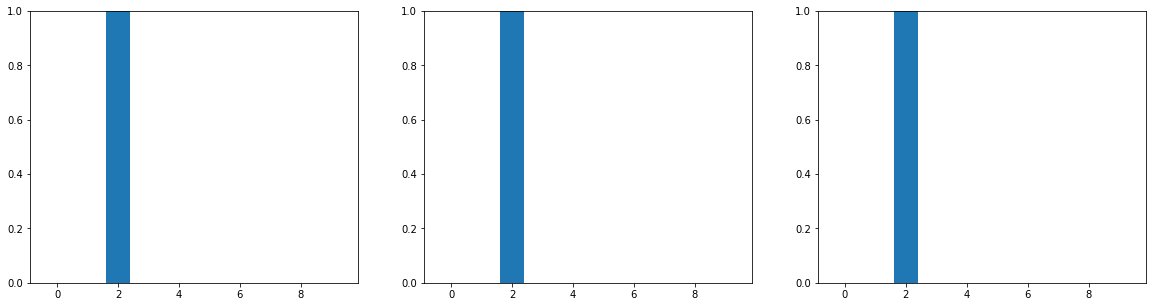

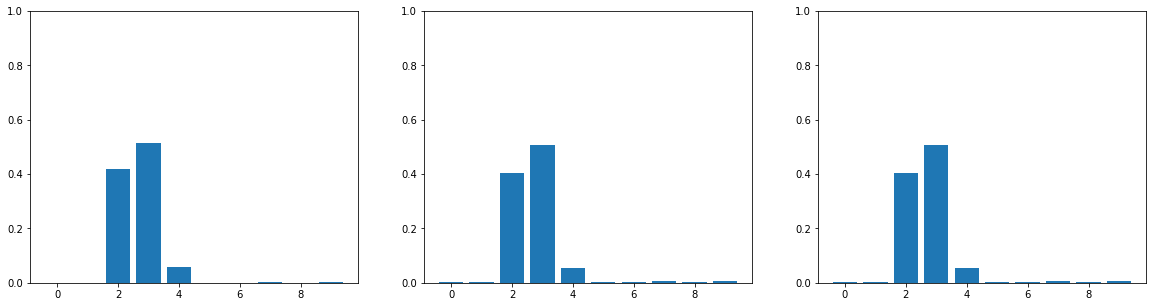

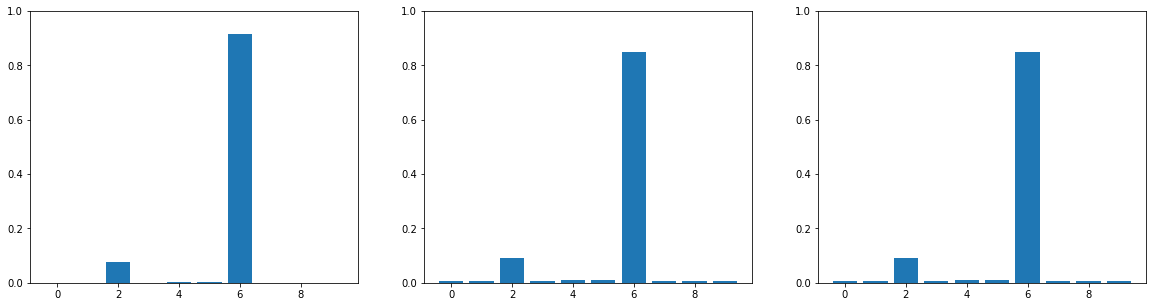

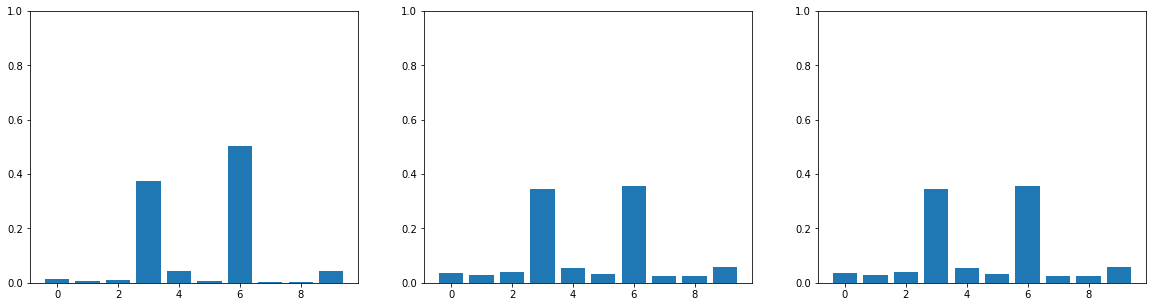

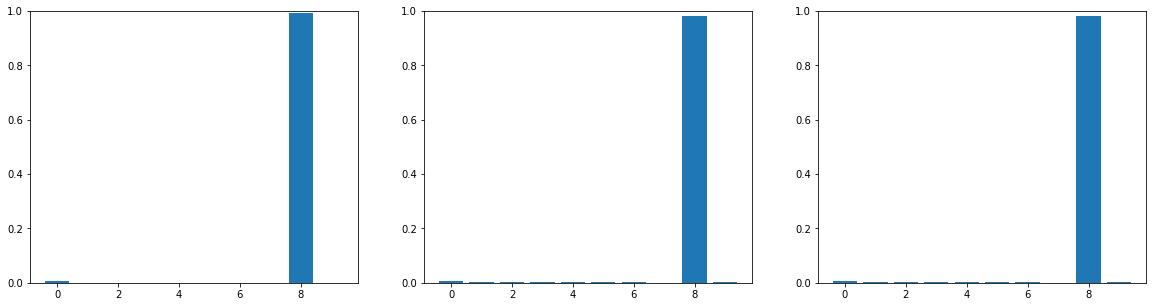

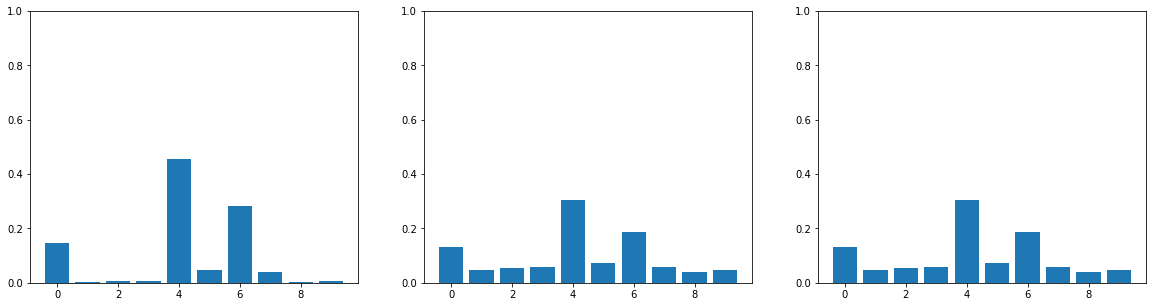

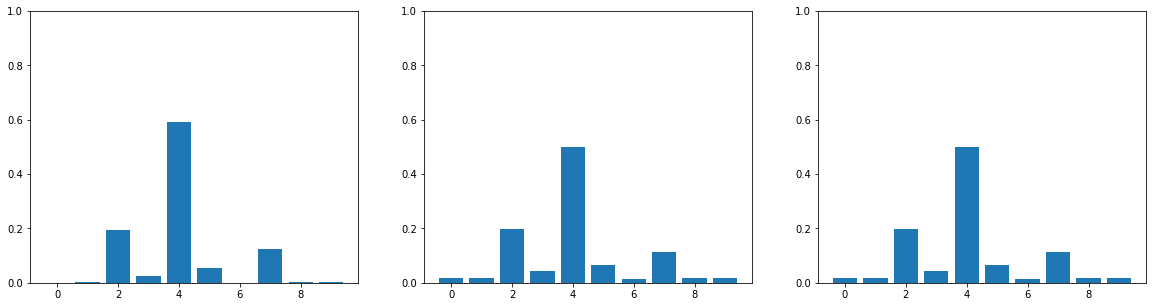

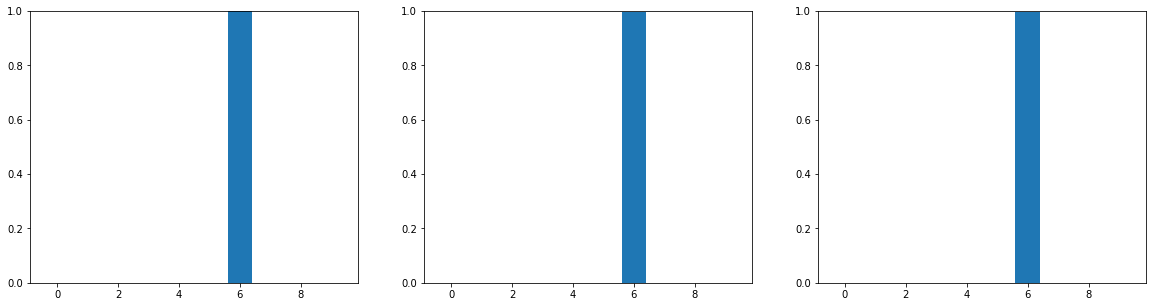

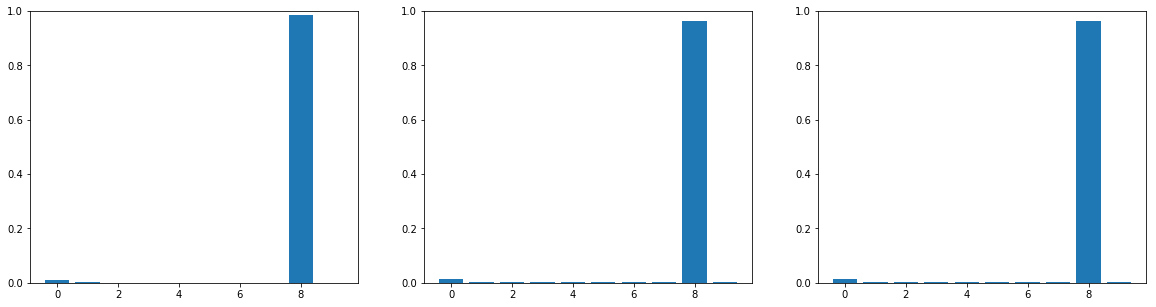

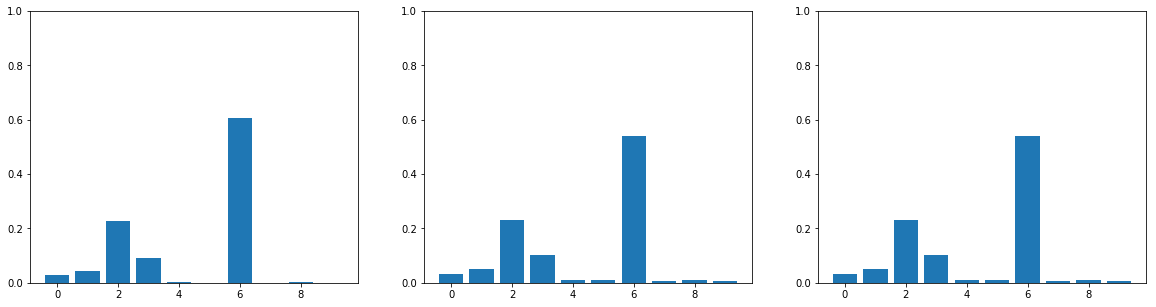

In [45]:
for idx in range(10):
    fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(20, 5))
    x = CIFAR10_test_out_CIFAR100_D[idx]
    x_d = CIFAR10_test_out_CIFAR100_DIR_LPAn[idx]
    x_db = CIFAR10_test_out_CIFAR100_DIR_LPA_bp[idx]
    
    print(x_d-x_db)
    axs[0].bar(range(10), x)
    axs[0].set_ylim(0,1)
    
    axs[1].bar(range(10), x_d)
    axs[1].set_ylim(0,1)
    
    axs[2].bar(range(10), x_db)
    axs[2].set_ylim(0,1)
    